In [1]:
import numpy as np
from scipy.linalg.interpolative import interp_decomp
import matplotlib.pyplot as plt

In [2]:
# Use scipy's implementation of the interpolative decomposition
# Instead of the matrix cross interpolation M = C @ P^-1 @ R
# it factorizes as M = A @ P with A = M[:, idx]
def interpolative_decomposition(M, eps_or_k=1e-5, k_min=2):
    r = min(M.shape)
    if r <= k_min:
        k = r
        idx, proj = interp_decomp(M, eps_or_k=k) #eps_or_k = precision of decomposition
    elif isinstance(eps_or_k, int): #checks if eps is an integer
        k = min(r, eps_or_k)
        idx, proj = interp_decomp(M, eps_or_k=k)
    else:
        k, idx,  proj = interp_decomp(M, eps_or_k=eps_or_k)
        if k <= k_min:
            k = min(r, k_min) #is it not enough to put k = k_min? 
                              #r>k_min otherwise first condition would have been true
            idx, proj = interp_decomp(M, eps_or_k=k)
    A = M[:, idx[:k]]
    P = np.concatenate([np.eye(k), proj], axis=1)[:, np.argsort(idx)]
    return A, P, k, idx[:k]

# k is the 'compressed' rank = number of pivot columns
# idx is the array with entries the indeces of the pivot columns
# proj = matrix R s.t. M[:,idx[:k]]*R = M[:,idx[k:]] 
# P = matrix s.t.  M[:,idx[:k]]*P = M (approximated)

In [ ]:
# implement the tensor cross interpolation
def tensor_cross_interpolation(tensor, L, d=2, eps_or_chi=1e-6, iters=6):
    # random initial choice for index sets
    idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma
    As = [np.array([[[tensor(*idxs[:j], i, *idxs[j+1:])] for i in range(d)]])
          for j in range(L)]
    As[1:] /= tensor(*idxs) # I don't know 
    I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l
    # sweep
    for i in range(iters):
        print(f'Sweep: {i+1:d}.')
        As, I = left_to_right_sweep(tensor, As, I, J, L, d, eps_or_chi)
        As, J = right_to_left_sweep(tensor, As, I, J, L, d, eps_or_chi)
    return As, J

def left_to_right_sweep(tensor, As, I, J, L, d, eps_or_chi):
    # sweep left to right
    for bond in range(L-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape #chil = number of rows in array I_l: number of combinations (σ1,..,σl)
        chir, _ = J[bond+1].shape #which corresponds to number of "points" on which I am evaluating function
        Pi = tensor(*I[bond].T[:, :, None, None, None],
                    np.arange(d)[None, :, None, None],
                    np.arange(d)[None, None, :, None],
                    *J[bond+1].T[:, None, None, None, :])\
            .reshape(chil * d, d * chir) #why this structure with square brackets?
        # decompose using interpolative decomposition:
        # Pi = P^T @ A^T, A^T = Pi[idx,:]
        A, P, k, idx = interpolative_decomposition(Pi.T, eps_or_k=eps_or_chi)
        # update indices using idxs c I[bond] x {0, 1, ..., d-1}
        I[bond+1] = np.array([np.append(I[bond][i//d], [i%d]) for i in idx])
        # update tensors
        As[bond] = P.T.reshape(chil, d, k)
        As[bond+1] = A.T.reshape(k, d, chir)
    return As, I

def right_to_left_sweep(tensor, As, I, J, L, d, eps_or_chi):
    # sweep right to left
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = tensor(*I[bond].T[:, :, None, None, None],
                    np.arange(d)[None, :, None, None],
                    np.arange(d)[None, None, :, None],
                    *J[bond+1].T[:, None, None, None, :])\
            .reshape(chil * d, d * chir)
        # decompose using interpolative decomposition:
        # Pi = A @ P, A = Pi[:,idx]
        A, P, k, idx = interpolative_decomposition(Pi, eps_or_k=eps_or_chi)
        # update indices using idxs c {0, 1, ..., d-1} x J[bond+1]
        J[bond] = np.array([np.append([i//chir], J[bond+1][i%chir]) for i in idx])
        # update tensors
        As[bond] = A.reshape(chil, d, k)
        As[bond+1] = P.reshape(k, d, chir)
    return As, J

In [22]:
#TEST:
L = 5

idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma

I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l

print(I)
print()
print(J)

bond = 3
chil, _ = I[bond].shape #chil = number of terms in array I_l
chir, _ = J[bond+1].shape

print(chil)


[array([], shape=(1, 0), dtype=int64), array([[5]]), array([[5, 0]]), array([[5, 0, 8]]), array([[5, 0, 8, 6]])]

[array([[0, 8, 6, 5]]), array([[8, 6, 5]]), array([[6, 5]]), array([[5]]), array([], shape=(1, 0), dtype=int64)]
1


Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.


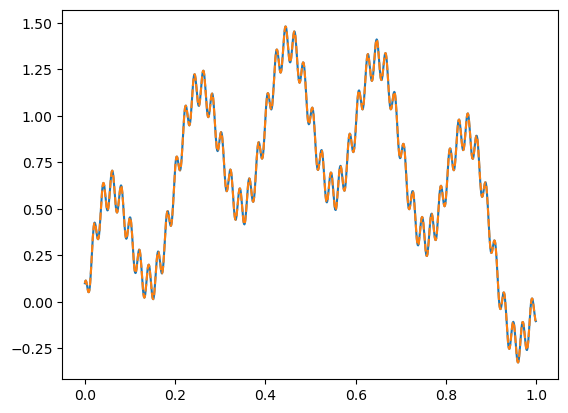

In [ ]:
# Example: create a function to interpolate
test_func = lambda x: 0.4 * np.sin(10 * np.pi * x)\
                    + 0.1 * np.cos(99 * np.pi * x)\
                    + 4 * x * (1 - x)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

# MPS from tensor cross interpolation
func = lambda *args: func_vals.reshape((2,)*10)[*args] #what?
As, _ = tensor_cross_interpolation(func,          # function to be interpolated
                                   L=10,          # number of MPS tensors
                                   eps_or_chi=10, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps

# Plot function and interpolation below

# contract full MPS (should only do this for small L <= 20)
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# plot result
plt.plot(xs, func_vals, '-')
plt.plot(xs, func_interp, '--')
plt.show()